# Explained features by intensity quartiles

Get khipus using updated grid,
Add new list of fragments
- Collect features that are explained;
- and numbers of unique empCpds

Plot how they overlap by each incremental quartile of features.

The candidate fragments are based on frequent delta m/zs. 

Not using those from MS2 as the freq lists here should be more inclusive.

Will move the frequent lists and top ones into mass2chem and khipu packages.

In [1]:
import io
import sys
import json
import tqdm
import contextlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from khipu.extended import peaklist_to_khipu_list, export_empCpd_khipu_list
sys.path.insert(0, '..')
from mining import * 

In [8]:
# Input data 

orbi_datasets = [x.rstrip() for x in open('selected_45_orbi_datasets.txt').readlines()]
pos_orbi_datasets = [x for x in orbi_datasets if 'pos' in x]
neg_orbi_datasets = [x for x in orbi_datasets if 'neg' in x]

# dict_tablefiles = {}
# for line in open('list_input_files.tsv').readlines():
#     a = line.rstrip().split('\t')
#     dict_tablefiles[a[0]] = a[1]

dict_rtwindow = {}
for line in open('elution_parameters_45studies_orbi.tsv').readlines()[1:]:
    a = line.rstrip().split('\t')
    dict_rtwindow[a[0]] = float(a[5])

**Next block is from last step without modification**

In [9]:
def get_features_in_rtwindow(list_features, rt_ref, rt_stdev):
    '''returns features in list_features that are within rt_stdev
    
    list_features: full list of features
    rt_ref: the reference retention time as the center of window
    rt_stdev: tolerance of retention time selecting
    
    return: list of features inside the given window
    '''
    return [f for f in list_features if abs(f['rtime']-rt_ref) <= rt_stdev]   

def get_khipus_in_rtwindow(list_khipus, rt_ref, rt_stdev):
    '''returns khipus in list_khipus that are within rt_stdev
    
    list_khipus: given list of khipus
    rt_ref: the reference retention time as the center of window
    rt_stdev: tolerance of retention time selecting
    
    return: list of khipus inside the given window
    '''
    return [f for f in list_khipus if abs(f['MS1_pseudo_Spectra'][0]['rtime']-rt_ref) <= rt_stdev]

def explain_a_dataset_by_mz_deltas(list_khipus, remaining_features, isf_candidate_fragments, rt_stdev=0.613):
    '''map the pairwise mass distance of the khipus and 'free' features to isf_candidate_fragments
    
    list_khipus: list of khipus
    remaining_features: list of orphan features
    isf_candidate_fragments: list of the most frequent delta mass values 
    rt_stdev: half window of rt tolerance
    
    return:
    explained_khipu_ids: list of explained khipu ids
    explained_feature_ids: list of explained feature ids
    delta_values_used: list of delta mz values used for explanation
    '''
    def mz_delta_in_list(mz, mlist, max_diff=0.0005, ppm=5):
        '''check if the given mz value is in given mz list(meet the requirement of certain number or ppm)
        
        mz: a float number of m/z delta value
        mlist: a list of m/z value
        max_diff: fixed number tolerance
        ppm: ppm tolerance
        
        return: a boolean value indicating if the given mz sits in the window of any mz value in the given mlist.
        '''
        r = False
        if mz > max_diff:
            deltas = sorted([abs(x-mz) for x in mlist])
            if deltas[0] <= max_diff or deltas[0]/mz < ppm*1e-6:
                r = True
        return r 
    
    explained_khipu_ids, explained_feature_ids, delta_values_used = [], [], []

    # iterate through given khipu list
    for ii in range(len(list_khipus)-1):
        # get rtime of current khipu
        rt_ref = list_khipus[ii]['MS1_pseudo_Spectra'][0]['rtime']
        # get mz of M0 feature in current khipu
        base_mz = get_M0(list_khipus[ii]['MS1_pseudo_Spectra'])['mz']
        # get list of khipus whose mass value is bigger than current one
        khipus_in_rtwindow = get_khipus_in_rtwindow(
            list_khipus[ii+1:], 
            rt_ref, 
            rt_stdev)
        # iterate through the khipus in rtime window to get whose delta to given one matching isf_candidate_fragments
        for k in khipus_in_rtwindow:
            _d = list_khipus[ii]['neutral_formula_mass']-k['neutral_formula_mass']
            if mz_delta_in_list(_d, isf_candidate_fragments):
                explained_khipu_ids.append(k['interim_id'])
                delta_values_used.append((_d, k['interim_id'], rt_ref-get_M0(k['MS1_pseudo_Spectra'])['rtime']))
        
        # iterate through the features in rtime window to get whose delta to given one matching isf_candidate_fragments
        features_in_rtwindow = get_features_in_rtwindow(
            remaining_features, 
            rt_ref, 
            rt_stdev)
        for f in features_in_rtwindow:
            _d = base_mz - f['mz']
            if mz_delta_in_list(_d, isf_candidate_fragments):
                explained_feature_ids.append(f['id'])
                delta_values_used.append((_d, f['id'], rt_ref-f['rtime']))
                
    return explained_khipu_ids, explained_feature_ids, delta_values_used

In [12]:
# pos ionization
isotope_search_patterns_pos = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            # (3.9948, '44Ca/40Ca', (0, 0.1)), # 2%
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            ]

isotope_search_patterns_neg = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            (1.9958, '32S/34S', (0, 0.1)), # 4%
                            ]

adduct_search_patterns_pos = [  # initial patterns are relative to M+H+
                            (21.98194, 'Na/H'),
                            (41.026549, 'ACN'),     # Acetonitrile
                            (67.987424, 'NaCOOH'),
                            (37.955882, 'K/H'),
                            (32.026215, 'MeOH')
                            ]
adduct_search_patterns_neg = [  
                            (21.98194, 'Na/H'), 
                            (67.987424, 'NaCOOH'),
                            (82.0030, 'C2HF3'),
                            # (1.99566, 'F <-> OH'), 
                            (41.026549, 'ACN'),
                            (37.955882, 'K/H'),
                            ]
extended_adducts = [  # excluding neutral loss here; include as a step after khipu
                            (1.0078, 'H'),
                            (17.02655, 'NH3'),
                            (18.0106, 'H2O'),      # easy to confuse with bio reactions
                            (18.033823, 'NH4'),
                            (27.01089904, 'HCN'),
                            (27.99492, 'CO'),
                            (32.026215, 'MeOH'),
                            (-35.037114, '-NH3-H2O'), # not incuded in candidates below
                            (35.9767, 'HCl'),
                            (37.94694, 'Ca/H2'),
                            (43.96389, 'Na2/H2'),
                            (46.00548, 'CO2H2'),
                            (67.987424, 'NaCOOH'),
                            (83.961361, 'KCOOH'),
                            (97.96737927, 'H2SO4'),
                            (97.97689507, 'H3PO4'),
]

pos_candidate_fragments = '''14.0155	900	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	{'C': 1, 'H': 2}
18.0104	885	18.010565	water	{'H': 2, 'O': 1}
2.0155	717	2.01565	± 2H, opening or forming of double bond	{'H': 2}
44.0261	652	44.0262	hydroxyethylation	{'C': 2, 'H': 4, 'O': 1}
28.0312	621	28.0313	± C2H4, natural alkane chains such as fatty acids	{'C': 2, 'H': 4}
15.9948	479	15.9949	oxidation	{'O': 1}
17.0264	451	17.0265	addition of ammonia. Reaction: (+NH3)	{'N': 1, 'H': 3}
26.0155	440	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	{'C': 2, 'H': 2}
27.9947	433	27.9949	addition of CO. Reaction: (+CO)	{'C': 1, 'O': 1}
42.0104	340	42.010564	malonylation and loss of CO2. Reaction: (+C3H2O3) and (-CO2)	{'C': 2, 'H': 2, 'O': 1}
67.9872	325	67.987424	NaCOOH	{'C': 1, 'O': 2, 'Na': 1, 'H': 1}
13.9791	321	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	{'H': -2, 'O': 1}
23.9998	317	24.0	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
16.0312	314	16.0313	Methylation + reduction	{'C': 1, 'H': 4}
42.0468	314	42.04695	± C3H6, propylation	{'C': 3, 'H': 6}
46.0053	313	46.005305	addition of Phosphate and dechlorination. Reaction: (+HPO3) and (-Cl+H)	{'H': 2, 'O': 3, 'P': 1, 'Cl': -1}
88.0522	304	88.052429	butanoic acid	{'C': 4, 'H': 8, 'O': 2}
41.0263	295	41.026549	Acetonitrile	{'C': 2, 'H': 3, 'N': 1}
22.9852	281	22.989218	 Na  	{ 'Na':1 }
30.0468	267	30.04695	addition of C2H4 and hydrogenation. Reaction: (+C2H4) and (+H2)	{'C': 2, 'H': 6}
'''
pos_candidate_fragments = [
    (float(x.split()[0]), x) for x in pos_candidate_fragments.splitlines()
]
pos_isf_candidate_fragments = [x[0] for x in pos_candidate_fragments]

In [13]:
def assign_intensity_quartile(list_features):
    '''
    example feature : {'id_number': 'F101',
                'id': 'F101',
                'mz': 113.8853,
                'rtime': 261.81,
                'apex': 261.81,
                'left_base': 261.02,
                'right_base': 263.65,
                'parent_masstrack_id': '1034',
                'peak_area': '433995',
                'cSelectivity': '0.75',
                'goodness_fitting': '0.98',
                'snr': '3',
                'detection_counts': '39',
                'representative_intensity': '433995'}
    returns dict {fid: quartile, ...}
    '''
    for f in list_features:
        f['peak_area'] = float(f['peak_area'])
    d = {}
    intensities = np.array([f['peak_area'] for f in list_features])
    x1, x2, x3 = np.quantile(intensities, 0.75
                        ), np.quantile(intensities, 0.5
                         ), np.quantile(intensities, 0.25)
    
    for f in list_features:
        if f['peak_area'] > x1:
            d[f['id']] = 1  # 1st quartile
        elif x1 >= f['peak_area'] > x2:
            d[f['id']] = 2
        elif x2 >= f['peak_area'] > x3:
            d[f['id']] = 3
        else:
            d[f['id']] = 4
    return d

In [18]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 50 minutes

tally_pos = []
for study in tqdm.tqdm(pos_orbi_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'pos'
        _n, list_features = read_features_from_asari_table(
            open(f'../input_data_orbi/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_pos, 
                                adduct_search_patterns=adduct_search_patterns_pos,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=5,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )
        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        remaining_features = [f for f in list_features if f['id'] not in all_assigned_fids]
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, pos_isf_candidate_fragments, 
            rt_stdev=dict_rtwindow[study]
            )

        dict_intensity_quartile = assign_intensity_quartile(list_features)
        preannotated_feature_ids = set(list(all_assigned_fids) + explained_feature_ids)
        quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]

        tally_pos.append(
            {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                'quartile_matches': quartile_matches,
            }
        )

  0%|          | 0/22 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 22/22 [46:21<00:00, 126.41s/it] 


In [21]:
test0 = tally_pos[0]['quartile_matches']
tally_pos[0]['num_features'], [
    len([x for x in test0 if x ==1]), len([x for x in test0 if x ==2]), 
    len([x for x in test0 if x ==3]), len([x for x in test0 if x ==4]),
]

(57875, [9775, 5046, 2097, 998])

In [23]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 

preannotated_features = [len(x['quartile_matches']) for x in tally_pos]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_pos]

quartile_percs = [[], [], [], []]
for x in tally_pos:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for ii in range(4):
        quartile_percs[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)
    
median_perc = [np.median(quartile_percs[ii]) for ii in range(4)]
median_perc

[67.12908255611669, 34.94841582257099, 18.964742758891756, 11.633603665197729]

17707.0 5568.0


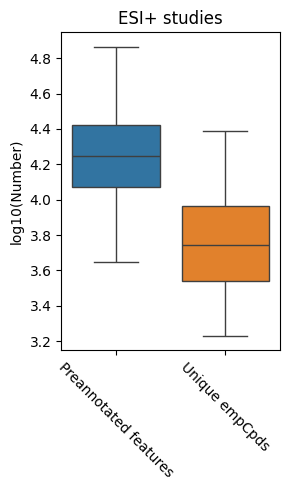

In [24]:
# Fig 3a. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
}

print(np.median(preannotated_features), np.median(unique_empCpds))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Number)")
ax.set_title("ESI+ studies")
plt.tight_layout()
plt.savefig('Fig3a_preannotation_pos.pdf')

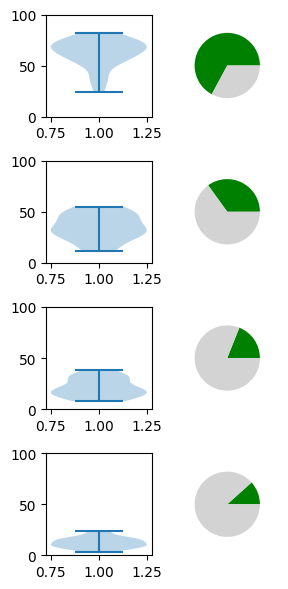

In [25]:
# Fig. 3b. distribution of perc; pie chart for median pec
# plot barplot for 
piedata = [(x, 100-x) for x in median_perc]

fig, axs = plt.subplots(4, 2, figsize=(3, 6))
for ii in range(4):
    axs[ii, 0].violinplot(quartile_percs[ii]) #, color='lg')
    axs[ii, 0].set_ylim(0, 100)
    axs[ii, 1].pie(piedata[ii], colors=['green', 'lightgray'], radius=.8) 
    
plt.tight_layout()
plt.savefig("Fig3b_preannotation_pos_piecharts.pdf")

## Do neg ion studies

In [26]:
neg_candidate_fragments = '''67.9874	819	67.987424	NaCOOH	"{'C': 1, 'O': 2, 'Na': 1, 'H': 1}"
14.0156	693	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	"{'C': 1, 'H': 2}"
2.0155	570	2.01565	"± 2H, opening or forming of double bond"	{'H': 2}
82.0029	431	82.003035	methylation and addition of trifluoromethyl. Reaction: (+CH2) and (+CF3-H)	"{'C': 2, 'H': 1, 'F': 3}"
15.9948	415	15.9949	oxidation	{'O': 1}
43.9898	394	43.9898	addition of CO2. Reaction: (+CO2)	"{'C': 1, 'O': 2}"
18.0105	374	18.010565	water	"{'H': 2, 'O': 1}"
11.9999	359	12	methylation and reduction	{'C': 1}
30.0105	352	30.010564	addition of acetic acid and loss of CO. Reaction: (+C2H2O2) and (-CO)	"{'C': 1, 'H': 2, 'O': 1}"
26.0156	346	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	"{'C': 2, 'H': 2}"
46.0054	339	46.005479	formic acid adduct	"{'C': 1, 'H': 2, 'O': 2}"
28.0312	327	28.0313	"± C2H4, natural alkane chains such as fatty acids"	"{'C': 2, 'H': 4}"
44.0261	303	44.0262	hydroxyethylation	"{'C': 2, 'H': 4, 'O': 1}"
27.9949	297	27.9949	addition of CO. Reaction: (+CO)	"{'C': 1, 'O': 1}"
23.9999	265	24	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
13.9792	256	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	"{'H': -2, 'O': 1}"
42.0105	250	42.010564	malonylation and loss of CO2. Reaction: (+C3H2O3) and (-CO2)	"{'C': 2, 'H': 2, 'O': 1}"
16.0312	239	16.0313	Methylation + reduction	"{'C': 1, 'H': 4}"
60.021	229	-60.0211	desmolysis	"{'C': -2, 'H': -4, 'O': -2}"
135.9748	222	135.974848	2X NaCOOH	"{'C': 2, 'O': 4, 'H': 2, 'Na': 2}"
'''
neg_candidate_fragments = [
    (float(x.split()[0]), x) for x in neg_candidate_fragments.splitlines()
]

isf_candidate_fragments_neg = [x[0] for x in neg_candidate_fragments]

In [27]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 70 minutes

tally_neg = []
for study in tqdm.tqdm(neg_orbi_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'neg'
        _n, list_features = read_features_from_asari_table(
            open(f'../input_data_orbi/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_neg, 
                                adduct_search_patterns=adduct_search_patterns_neg,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=5,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )
        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        remaining_features = [f for f in list_features if f['id'] not in all_assigned_fids]
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, isf_candidate_fragments_neg, 
            rt_stdev=dict_rtwindow[study]
            )

        dict_intensity_quartile = assign_intensity_quartile(list_features)
        preannotated_feature_ids = set(list(all_assigned_fids) + explained_feature_ids)
        quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]

        tally_neg.append(
            {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                'quartile_matches': quartile_matches,
            }
        )

100%|██████████| 23/23 [1:01:15<00:00, 159.79s/it]


In [28]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 

preannotated_features = [len(x['quartile_matches']) for x in tally_neg]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_neg]

quartile_percs = [[], [], [], []]
for x in tally_neg:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for ii in range(4):
        quartile_percs[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)
    
median_perc = [np.median(quartile_percs[ii]) for ii in range(4)]
median_perc

[61.00745080557855, 36.64845758354756, 19.98001998001998, 14.544096905334772]

17774.0 6060.0


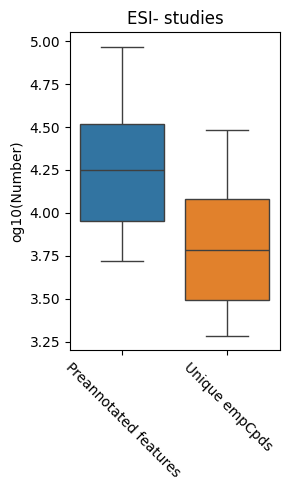

In [29]:
# Fig 3c. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
}

print(np.median(preannotated_features), np.median(unique_empCpds))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("og10(Number)")
ax.set_title("ESI- studies")
plt.tight_layout()
plt.savefig('Fig3c_preannotation_neg.pdf')

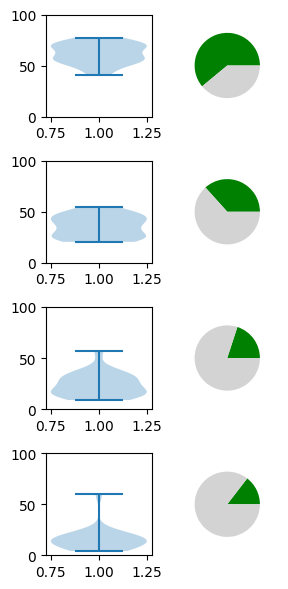

In [30]:
# Fig. 3d. distribution of perc; pie chart for median pec
# plot barplot for 
piedata = [(x, 100-x) for x in median_perc]

fig, axs = plt.subplots(4, 2, figsize=(3, 6))
for ii in range(4):
    axs[ii, 0].violinplot(quartile_percs[ii]) #, color='lg')
    axs[ii, 0].set_ylim(0, 100)
    axs[ii, 1].pie(piedata[ii], colors=['green', 'lightgray'], radius=.8) 
    
plt.tight_layout()
plt.savefig("Fig3d_preannotation_neg_piecharts.pdf")

# Conclusion

This notebook plots Figure 3. 

Numbers of pre-annotated features by extended khipus in all studies.
a,b. Distribution of numbers of pre-annotated features, median value 17,499 and 17,974 for positive and negative ionization datasets, respectively. They correspond to 5,675 and 6,224 unique empirical compounds, respectively.

 c,d. Percentage distribution of pre-annotated features in each intensity quartile in each study, for positive and negative ionization datasets, respectively. The pie charts show median percentage in each quartile, respectively. 